## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
import wordcloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file
f = open('complaints-2021-05-14_08_16.json')# Write the path to your data file and load it

# returns JSON object as
# a dictionary
pd.set_option("max_colwidth", None)
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.
print(df.shape)
df.head(5)


(78313, 22)


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [4]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [5]:
#Assign new column names
# We can replace _ and source. to make column names more readable
col_regex = "^_(source.)?"
df.columns = [re.sub(col_regex, "", col) for col in df.columns]
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [6]:
#Assign nan in place of blanks in the complaints column
whitespace_regex = r'^\s*$'
df["complaint_what_happened"] = df["complaint_what_happened"].apply(lambda x : np.nan if re.search(whitespace_regex, x) else x)
print("There are {0} complaints with Blank value".format(df["complaint_what_happened"].isnull().sum()))

There are 57241 complaints with Blank value


In [7]:
#Remove all rows where complaints column is nan
df = df[~(df["complaint_what_happened"].isnull())]
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [8]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
    #Make text to lower case
    text=text.lower()
    #Remove text in quare brackets
    brackets_regex = r'\[.*?\]'
    text = re.sub(brackets_regex, '', text)
    #Remove punctuations using string.punctuation
    text = ''.join(c for c in text if c not in string.punctuation)
    #Remove words containing numbers
    numbers_regex = r'[^\s]*[\d]+[^\s]*'
    text = re.sub(numbers_regex, '', text)

    return text

In [9]:
cleaned_complaints = df["complaint_what_happened"].apply(clean_text)

In [10]:
#Write your function to Lemmatize the texts
def lemmatize_text(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return " ".join(lemmas)

In [11]:
lemmatized_complaints = cleaned_complaints.apply(lemmatize_text)

In [12]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
pd.set_option("max_colwidth", 500)
df_clean = pd.DataFrame({"complaints" : df["complaint_what_happened"], "lemmatized_complaints" : lemmatized_complaints})
df_clean.reset_index(drop = True, inplace = True)

In [13]:
df_clean

,complaints,lemmatized_complaints
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase re...",on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my information for the offer and within less than a minute be notify via the screen that a decision could not be make I immediately contact xxxx and be refer to chase bank I then immediately contact chase bank within no more than of get the notification on the screen and I be tell by the chase representative I speak with that my application be deny...
4,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase 2 times they told him i should call not him to verify the check owner he is out the country most the time date happen XX/XX/2018 check number XXXX claim number is XXXX with chase,my grand son give I check for I deposit it into my chase account after fund clear my chase bank close my account never pay I my money they say they need to speek with my grand son check be clear money be take by my chase bank refuse to pay I my money my grand son call chase time they tell he I should call not he to verify the check owner he be out the country most the time date happen check number xxxx claim number be xxxx w

In [14]:
#Write your function to extract the POS tags

def pos_tag(text):
    # Tokenize the text
    doc = nlp(text)
    # Get the POS tags
    pos_tags = [(token.text, token.tag_) for token in doc]
    return pos_tags

def remove_pos_tags(text):
    #Tokenize the text
    doc = nlp(text)
    # Filter out words with the NN Tags
    filtered_tokens = [token.text for token in doc if token.tag_ == "NN"]
    # Join the filtered tokens back together
    filtered_text = " ".join(filtered_tokens)

    return filtered_text

pos_tags = df_clean["lemmatized_complaints"].apply(pos_tag)
df_clean["complaint_POS_removed"] = df_clean["lemmatized_complaints"].apply(lambda text: remove_pos_tags(text))  #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


In [15]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaints,lemmatized_complaints,complaint_POS_removed
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank service ask debt verification statement bank debt mail month debt right information consumer chase account xxxx advance help
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,xxxx card agent anniversary date agent information order account xxxx anniversary date consent recording agent
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,chase card report application identity consent service credit identity applicant
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase re...",on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my information for the offer and within less than a minute be notify via the screen that a decision could not be make I immediately contact xxxx and be refer to chase bank I then immediately contact chase bank within no more than of get the notification on the screen and I be tell by the chase representative I speak with that my application be deny...,xxxx xxxx ticket offer ticket reward card information offer minute screen decision xxxx refer bank chase bank notification screen representative application information xxxx credit offer account statement use ticket account application oblige application request application representative chase fact credit account name report credit report chase information credit report application error
4,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money th

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




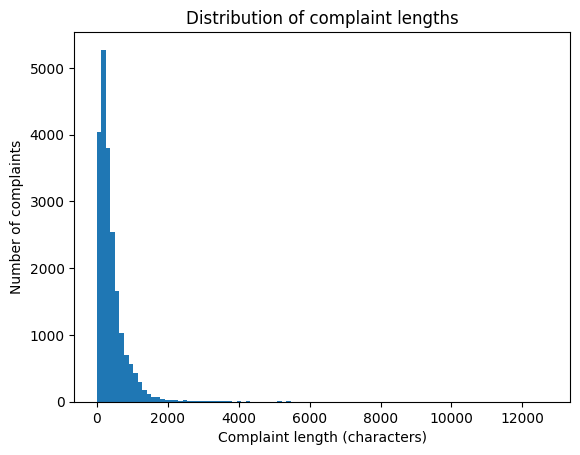

In [16]:
# Write your code here to visualise the data according to the 'Complaint' character length
complaint_lengths = df_clean["complaint_POS_removed"].str.len()
# Plot the distribution of the complaint lengths
plt.hist(complaint_lengths, bins =100)
plt.xlabel("Complaint length (characters)")
plt.ylabel("Number of complaints")
plt.title("Distribution of complaint lengths")
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

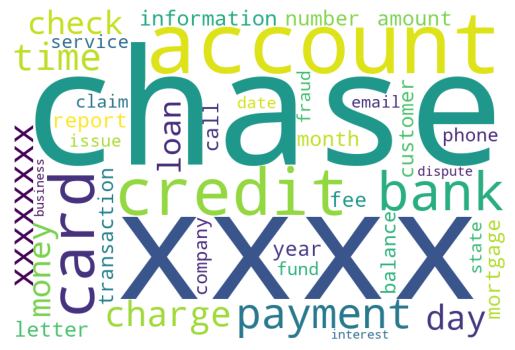

In [17]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
def create_wordcloud(text):
    # Create a WordCloud object
    word_cloud = wordcloud.WordCloud(
      max_words=40,
      background_color="white",
      width=750,
      height=500,
      random_state=100,
      collocations = False,
      stopwords=set(wordcloud.STOPWORDS)
    )

    # Generate the word cloud
    word_cloud.generate(text)

    return word_cloud

top40_word_cloud = create_wordcloud(df_clean["complaint_POS_removed"].str.cat(sep=" "))

# Display the word cloud
plt.imshow(top40_word_cloud)
plt.axis("off")
plt.show()

In [18]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [19]:
def get_top_n_grams_df(df, column, n):
    # Create a CountVectorizer object
    vectorizer = CountVectorizer(ngram_range=(n, n))
    # Fit the vectorizer to the data frame column
    vectorizer.fit(df[column])
    # Transform the data frame column into a dense matrix
    bow = vectorizer.transform(df[column])
    # Get the counts
    counts = bow.sum(axis=0)
    words_freq = [(word, counts[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:30]


In [20]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
top_30_uni = get_top_n_grams_df(df_clean, 'Complaint_clean',1)
top_30_uni

[('chase', 52744),
 ('xxxx', 48182),
 ('account', 46732),
 ('credit', 33464),
 ('card', 30216),
 ('bank', 21612),
 ('payment', 21159),
 ('time', 16008),
 ('charge', 14153),
 ('xxxxxxxx', 13582),
 ('day', 12971),
 ('check', 12100),
 ('money', 11953),
 ('loan', 10899),
 ('information', 9643),
 ('letter', 9598),
 ('fee', 8890),
 ('report', 8855),
 ('number', 8614),
 ('transaction', 8564),
 ('month', 8461),
 ('amount', 8422),
 ('call', 8365),
 ('year', 8289),
 ('customer', 8137),
 ('mortgage', 8072),
 ('balance', 7759),
 ('service', 7698),
 ('phone', 7570),
 ('company', 7534)]

In [21]:
#Print the top 10 words in the unigram frequency
top_30_uni[:10]

[('chase', 52744),
 ('xxxx', 48182),
 ('account', 46732),
 ('credit', 33464),
 ('card', 30216),
 ('bank', 21612),
 ('payment', 21159),
 ('time', 16008),
 ('charge', 14153),
 ('xxxxxxxx', 13582)]

In [22]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
top_30_bi = get_top_n_grams_df(df_clean, 'Complaint_clean',2)
top_30_bi

[('credit card', 12842),
 ('xxxx xxxx', 5029),
 ('credit report', 3927),
 ('customer service', 3058),
 ('account chase', 2805),
 ('chase credit', 2783),
 ('chase account', 2523),
 ('bank account', 2392),
 ('check account', 2245),
 ('account account', 2077),
 ('chase bank', 2062),
 ('debit card', 1965),
 ('checking account', 1847),
 ('chase card', 1727),
 ('credit score', 1707),
 ('account xxxx', 1687),
 ('phone call', 1650),
 ('number xxxx', 1641),
 ('xxxx credit', 1620),
 ('card account', 1608),
 ('xxxx chase', 1601),
 ('card chase', 1481),
 ('xxxx account', 1413),
 ('account credit', 1388),
 ('chase xxxx', 1315),
 ('interest rate', 1288),
 ('business day', 1253),
 ('money account', 1252),
 ('account bank', 1243),
 ('phone number', 1240)]

In [23]:
#Print the top 10 words in the bigram frequency
top_30_bi[:10]

[('credit card', 12842),
 ('xxxx xxxx', 5029),
 ('credit report', 3927),
 ('customer service', 3058),
 ('account chase', 2805),
 ('chase credit', 2783),
 ('chase account', 2523),
 ('bank account', 2392),
 ('check account', 2245),
 ('account account', 2077)]

In [24]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
top_30_tri = get_top_n_grams_df(df_clean, 'Complaint_clean',3)
top_30_tri

[('chase credit card', 1881),
 ('credit card account', 1066),
 ('credit card company', 981),
 ('xxxx credit card', 786),
 ('xxxx xxxx xxxx', 784),
 ('credit card chase', 683),
 ('inquiry credit report', 488),
 ('credit card credit', 478),
 ('credit card xxxx', 398),
 ('account credit card', 395),
 ('chase customer service', 385),
 ('credit reporting agency', 382),
 ('charge credit card', 372),
 ('chase checking account', 371),
 ('card credit card', 358),
 ('credit report credit', 347),
 ('customer service representative', 339),
 ('credit reporting act', 338),
 ('credit card payment', 293),
 ('chase bank account', 278),
 ('credit card charge', 269),
 ('account number xxxx', 264),
 ('account credit report', 258),
 ('bank credit card', 256),
 ('chase card service', 255),
 ('chase auto finance', 253),
 ('victim identity theft', 251),
 ('account chase account', 250),
 ('credit card balance', 250),
 ('credit card card', 238)]

In [25]:
#Print the top 10 words in the trigram frequency
top_30_tri[:10]

[('chase credit card', 1881),
 ('credit card account', 1066),
 ('credit card company', 981),
 ('xxxx credit card', 786),
 ('xxxx xxxx xxxx', 784),
 ('credit card chase', 683),
 ('inquiry credit report', 488),
 ('credit card credit', 478),
 ('credit card xxxx', 398),
 ('account credit card', 395)]

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [26]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [27]:
#All masked texts has been removed
df_clean

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank service ask debt verification statement bank debt mail month debt right information consumer chase account xxxx advance help,morning name stop bank service ask debt verification statement bank debt mail month debt right information consumer chase account advance help
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,xxxx card agent anniversary date agent information order account xxxx anniversary date consent recording agent,card agent anniversary date agent information order account anniversary date consent recording agent
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,chase card report application identity consent service credit identity applicant,chase card report application identity consent service credit identity applicant
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase re...",on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my information for the offer and within less than a minute be notify via the screen that a decision could not be make I immediately contact xxxx and be refer to chase bank I then immediately contact chase bank within no more than of get the notification on the screen and I be tell by the chase representative I speak with that my application be deny...,xxxx xxxx ticket offer ticket reward card information offer minute screen decision xxxx refer bank chase bank notification screen representative application information xxxx credit offer account statement

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [28]:
#Write your code here to initialise the TfidfVectorizer
tf_idf_vectorizer = TfidfVectorizer(max_df = 0.95, min_df = 2, stop_words = "english",  ngram_range = (1, 3), max_features=10000)


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [29]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
doc_term_matrix= tf_idf_vectorizer.fit_transform(df_clean['Complaint_clean'])

In [30]:
vocab = np.array(tf_idf_vectorizer.get_feature_names_out())
print("Vocabulary size :",len(vocab))

Vocabulary size : 10000


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [32]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [33]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components = num_topics, random_state = 40)
W = nmf_model.fit_transform(doc_term_matrix)
H = nmf_model.components_

topic_top15words = pd.DataFrame(np.zeros((num_topics, 15)), columns = [f'Word {i+1}' for i in range(15)],
             index = [f'Topic {i+1}' for i in range(num_topics)]).astype("str")

for i in range(num_topics) :
  idx = H[i].argsort()[::-1][:15]
  topic_top15words.iloc[i] = vocab[idx]

topic_top15words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,chase,fund,deposit,transaction,day,branch,claim,number,check account,account account,bank account
Topic 2,card,credit,credit card,charge,chase,dispute,chase credit,purchase,chase credit card,company,service,merchant,balance,fraud,time
Topic 3,loan,mortgage,chase,home,modification,property,year,document,foreclosure,letter,time,rate,sale,house,loan modification
Topic 4,report,credit,inquiry,credit report,inquiry credit,inquiry credit report,report credit,account,debt,reporting,score,information,identity,credit reporting,credit report credit
Topic 5,payment,payment payment,balance,fee,month,statement,payment chase,chase payment,chase,time,account payment,credit,payment account,payment credit,day


All the topics are Valid here, lets repeat the process by increasing the num_topics & validate.

In [34]:
num_topics = 6

#keep the random_state =40
nmf_model = NMF(n_components = num_topics, random_state = 40)
W = nmf_model.fit_transform(doc_term_matrix)
H = nmf_model.components_

topic_top15words = pd.DataFrame(np.zeros((num_topics, 15)), columns = [f'Word {i+1}' for i in range(15)],
             index = [f'Topic {i+1}' for i in range(num_topics)]).astype("str")

for i in range(num_topics) :
  idx = H[i].argsort()[::-1][:15]
  topic_top15words.iloc[i] = vocab[idx]

topic_top15words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,fund,deposit,chase,branch,day,check account,account account,bank account,checking,business,number
Topic 2,card,credit,credit card,chase,chase credit,chase credit card,account,balance,card chase,card credit,card account,chase card,card card,score,limit
Topic 3,loan,mortgage,home,modification,chase,property,year,rate,foreclosure,document,time,house,sale,loan modification,letter
Topic 4,report,inquiry,credit,credit report,inquiry credit,inquiry credit report,report credit,information,reporting,debt,identity,company,account,credit reporting,credit report credit
Topic 5,payment,payment payment,balance,fee,month,statement,payment chase,chase payment,chase,time,account payment,day,auto,payment account,payment credit
Topic 6,charge,dispute,chase,transaction,merchant,claim,fraud,fee,purchase,email,service,refund,time,company,card


Topic 6 looks like a repeated topic.

Let's repeat the process by increase num_topics to 7 and see what topics we get

In [35]:
num_topics = 7

#keep the random_state =40
nmf_model = NMF(n_components = num_topics, random_state = 40)
W = nmf_model.fit_transform(doc_term_matrix)
H = nmf_model.components_

topic_top15words = pd.DataFrame(np.zeros((num_topics, 15)), columns = [f'Word {i+1}' for i in range(15)],
             index = [f'Topic {i+1}' for i in range(num_topics)]).astype("str")

for i in range(num_topics) :
  idx = H[i].argsort()[::-1][:15]
  topic_top15words.iloc[i] = vocab[idx]

topic_top15words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,bank,money,chase,account account,chase account,account chase,branch,bank account,fund,checking,transfer,transaction,number,checking account
Topic 2,card,credit,credit card,chase,chase credit,chase credit card,balance,card chase,card credit,chase card,card card,card account,score,limit,point
Topic 3,loan,mortgage,home,modification,chase,property,year,rate,foreclosure,document,house,sale,time,loan modification,letter
Topic 4,report,inquiry,credit,credit report,inquiry credit,inquiry credit report,report credit,reporting,information,debt,company,identity,credit reporting,credit report credit,credit inquiry
Topic 5,payment,payment payment,balance,fee,month,statement,payment chase,chase payment,chase,time,day,auto,account payment,payment credit,payment month
Topic 6,charge,dispute,chase,transaction,merchant,claim,fraud,fee,purchase,email,service,refund,time,day,company
Topic 7,check,bank,deposit,fund,money,check account,day,cash,check check,branch,chase,check deposit,bank check,hold,account check


Topic 6 & 7 looks like a repeated topic.

At max 5 topics can be extracted with this dataset.

In [36]:
num_topics = 5
nmf_model = NMF(n_components = num_topics, random_state = 40)
W = nmf_model.fit_transform(doc_term_matrix)
H = nmf_model.components_

topic_top15words = pd.DataFrame(np.zeros((num_topics, 15)), columns = [f'Word {i+1}' for i in range(15)],
                                index = [f'Topic {i+1}' for i in range(num_topics)]).astype("str")

for i in range(num_topics) :
  idx = H[i].argsort()[::-1][:15]
  topic_top15words.iloc[i] = vocab[idx]

topic_top15words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,chase,fund,deposit,transaction,day,branch,claim,number,check account,account account,bank account
Topic 2,card,credit,credit card,charge,chase,dispute,chase credit,purchase,chase credit card,company,service,merchant,balance,fraud,time
Topic 3,loan,mortgage,chase,home,modification,property,year,document,foreclosure,letter,time,rate,sale,house,loan modification
Topic 4,report,credit,inquiry,credit report,inquiry credit,inquiry credit report,report credit,account,debt,reporting,score,information,identity,credit reporting,credit report credit
Topic 5,payment,payment payment,balance,fee,month,statement,payment chase,chase payment,chase,time,account payment,credit,payment account,payment credit,day


#### Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

In [38]:
document_topic = pd.DataFrame(W, columns = [f'Topic {i + 1}' for i in range(num_topics)])
document_topic["Dominant_Topic"] = document_topic.apply(lambda x : np.argmax(x), axis = 1)
document_topic.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Dominant_Topic
0,0.019439,0.003725,0.014386,0.011811,0.006139,0
1,0.006927,0.014123,0.004599,0.001145,0.000616,1
2,0.000000,0.030181,0.001108,0.043361,0.000000,3
3,0.014445,0.020970,0.011340,0.065416,0.000000,3
4,0.057129,0.000000,0.006541,0.000000,0.000000,0


In [40]:
df_clean['Topic'] = document_topic["Dominant_Topic"]
df_clean.sample(5)

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
20132,"I signed up for the Chase XXXX card in XX/XX/XXXX when the card was offering a "" uncapped anniversary free night at any of their XXXX hotels. '' On XX/XX/XXXX, they announced all customers would have their uncapped night limited to XXXX points and with a very resteictive list of hotels. They then backtracked a little and allowed said "" customers who signed up from XX/XX/XXXX to XX/XX/XXXX will still get an uncapped anniversary free night their first year. '' That leaves all customers who s...",I sign up for the chase xxxx card in xxxxxxxx when the card be offer a uncapped anniversary free night at any of their xxxx hotel on xxxxxxxx they announce all customer would have their uncapped night limit to xxxx point and with a very resteictive list of hotel they then backtrack a little and allow say customer who sign up from xxxxxxxx to xxxxxxxx will still get an uncapped anniversary free night their first year that leave all customer who still sign up for the offer who hav...,chase card xxxxxxxx card anniversary night xxxx hotel customer night limit point list hotel customer anniversary night year customer offer chance year annivery night night customer option time phone support customer year customer xxxxxxxxto window night year night xxxxxxxx anyone condition night opportunity anniversary night consumer fix credit card company grandfather customer year,chase card card anniversary night hotel customer night limit point list hotel customer anniversary night year customer offer chance year annivery night night customer option time phone support customer year customer to window night year night anyone condition night opportunity anniversary night consumer fix credit card company grandfather customer year,1
10564,I am reporting a few things. I found numerous fraudulent transactions by either a fake company or companies that was able to obtain my routing number and account number from Chase and be able to run {$20.00} ACH transactions. \n\nI was only able to pull 24 months of reporting from today XX/XX/XXXX and found weekly deductions of {$20.00}. \n\nI was able to research from XX/XX/XXXX - XX/XX/XXXX and found eight companies charging me as follow : 1 ) XX/XX/XXXX - XX/XX/XXXX : XXXX XXXX XXXX WEB I...,I be report a few thing I find numerous fraudulent transaction by either a fake company or company that be able to obtain my routing number and account number from chase and be able to run ach transaction \n\n I be only able to pull month of report from today xxxxxxxx and find weekly deduction of \n\n I be able to research from xxxxxxxx xxxxxxxx and find eight company charge I as follow xxxxxxxx xxxxxxxx xxxx xxxx xxxx web i d xxxx transaction each total xxxxxxxx ...,report thing transaction company company routing number account number chase ach transaction month report today deduction company xxxxxxxx xxxxxxxx xxxx transaction xxxxxxxx xxxx transaction xxxxxxxx xxxx transaction xxxxxxxx xxxx transaction xxxxxxxx xxxx xxxx transaction xxxxxxxx xxxx transaction xxxxxxxx payment xxxx transaction xxxxxxxx xxxx xxxx transaction year charge day window policy activity chase activity,report thing transaction company company routing number account number chase ach transaction month report today deduction company transaction transaction transaction transaction transaction transaction payment transaction transaction year charge day window policy activity chase activity,0
3679,"XX/XX/2020 at XXXX XXXX I answered the call after ignoring 15+ times, or getting to the phone late. I let the man named XXXX finish his intro and let him know "" Do not call '' I repeated this phrase over 5 times giving him a chance to respond each one, he demanded to know who I am or else he can not file the DNC and they will keep calling. I have done collections myself and know that you can mark a phone number as DNC without having an account pulled up.",at xxxx xxxx I answer the call

#### Print the first 5 Complaint for each of the Topics

Validating the document topic mapping

In [42]:
df_clean.groupby('Topic').head(5).sort_values(by = "Topic")

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank service ask debt verification statement bank debt mail month debt right information consumer chase account xxxx advance help,morning name stop bank service ask debt verification statement bank debt mail month debt right information consumer chase account advance help,0
4,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase 2 times they told him i should call not him to verify the check owner he is out the country most the time date happen XX/XX/2018 check number XXXX claim number is XXXX with chase,my grand son give I check for I deposit it into my chase account after fund clear my chase bank close my account never pay I my money they say they need to speek with my grand son check be clear money be take by my chase bank refuse to pay I my money my grand son call chase time they tell he I should call not he to verify the check owner he be out the country most the time date happen check number xxxx claim number be xxxx with chase,son chase account fund chase bank account money son check money chase bank money son chase time check owner country time date check number claim number xxxx chase,son chase account fund chase bank account money son check money chase bank money son chase time check owner country time date check number claim number chase,0
10,mishandling of this account by Chase auto and XXXX.,mishandle of this account by chase auto and xxxx,mishandle account chase auto xxxx,mishandle account chase auto,0
6,With out notice J.P. Morgan Chase restricted my account by my debit card Tuesday XX/XX/2019. On Thursday XX/XX/2019 I went into A branch after being advised by a customer service representative that my account would actually be closed. I went into the branch to see how I can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned. The bank associate and the customer service representative assured me that the funds would Po...,with out notice jp morgan chase restrict my account by my debit card tuesday on thursday I go into a branch after be advise by a customer service representative that my account would actually be close I go into the branch to see how I can remove the fund that be in there currently in as well as if my direct deposit from my place of employment would be return the bank associate and the customer service representative assure I that the fund would post but they may take an additional busine...,notice account debit card branch customer service representative account branch fund deposit place employment bank associate customer service representative assure fund business day branch fund post look account fund statement call business day state date fund ba

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [44]:
topic_name_mapping = {0 : "Bank Account services", 1 : "Credit card/Prepaid card", 2 : "Mortgage/Loan", 3 : "Others", 4 : "Theft/Dispute Reporting"}
df_clean['Topic'] = df_clean['Topic'].map(topic_name_mapping)
df_clean.sample(5)

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
9183,"A XXXX Scammer from XXXX mailed me a counterfeit check which I deposited into the Chase bank on XXXX XXXX XXXX in XXXX , IL. Chase then closed this account and sent it to collections. I sent chase a check to pay this off recently to XXXX XXXX and have offered them other methods to pay off the debt and bring an account with my name on it into the positive and they refuse to. Why is everyone giving me a hard time? Either by scamming me or not accepting my forms of payment?...",a xxxx scammer from xxxx mail I a counterfeit check which I deposit into the chase bank on xxxx xxxx xxxx in xxxx il chase then close this account and send it to collection I send chase a check to pay this off recently to xxxx xxxx and have offer they other method to pay off the debt and bring an account with my name on it into the positive and they refuse to why be everyone give I a hard time either by scamme I or not accept my form of payment why do not t...,xxxx xxxx mail check bank xxxx account collection chase check xxxx method debt account name everyone time scamme form payment scam medium internet mail tv email chase bank money world money,mail check bank account collection chase check method debt account name everyone time scamme form payment scam medium internet mail tv email chase bank money world money,Bank Account services
11344,"Due to A serious illness we applied for A loan modification from years XX/XX/XXXX to XX/XX/XXXX to lower our payments and interest rates down from 8/12 per cent so we could afford the payments. The process proceeded on until the house was under water with no conclusion on the loan modification application process. The amount of money went from XXXX XXXX XXXX XXXX XXXX, to XXXX XXXX XXXX XXXX XXXX during this time.",due to a serious illness we apply for a loan modification from year xxxxxxxx to xxxxxxxx to lower our payment and interest rate down from per cent so we could afford the payment the process proceed on until the house be under water with no conclusion on the loan modification application process the amount of money go from xxxx xxxx xxxx xxxx xxxx to xxxx xxxx xxxx xxxx xxxx during this time,illness loan modification year xxxxxxxx payment interest rate cent payment process house water conclusion loan modification application process amount money time,illness loan modification year payment interest rate cent payment process house water conclusion loan modification application process amount money time,Mortgage/Loan
1748,"The deferment, or forbearance, offered by Chase bank, because of the CV 19 circumstance, requires that I pay in FULL XXXX months at the End of the deferment, instead of rolling into the loan. This makes NO sense whatsoever! Im furious",the deferment or forbearance offer by chase bank because of the cv circumstance require that I pay in full xxxx month at the end of the deferment instead of roll into the loan this make no sense whatsoever I m furious,deferment forbearance offer cv circumstance xxxx month end deferment roll loan sense,deferment forbearance offer cv circumstance month end deferment roll loan sense,Mortgage/Loan
11749,"My sister passed away in XX/XX/XXXX without a will. I went to XXXX ( I live in XXXX XXXX and gathered all of her documents ( I had a POA ) and went to the local Chase bank to inquire about some discrepancies on her account. They were extremely rude and told me to report any suspicious activity to the local police, which I did. Long story short, I finally got that resolved after months of making calls and basically being given the run around. I then decided to close her accounts but was tol...",my sister pass away in xxxxxxxx without a will I go to xxxx I live in xxxx xxxx and gather all of her document I have a poa and go to the local chase bank to inquire about some discrepancy on her account they be extremely rude and tell I to report any suspicious activity to the local police whi

## Supervised model to predict any new complaints to the relevant Topics.

We have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since we will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [46]:
topic_name_idx_mapping = {"Bank Account services" : 0, "Credit card/Prepaid card" : 1, "Mortgage/Loan" : 2 , "Others" : 3, "Theft/Dispute Reporting" : 4}
df_clean['Topic'] = df_clean['Topic'].map(topic_name_idx_mapping)
df_clean.sample(5)

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
17379,"I strongly disagree with Chase 's policy that prevents people from depositing cash into another person 's account. I asked a friend to deposit money into my account and he was rejected by Chase 's branch in XXXX, Texas. He was forced to go buy a money order and come back to make the deposit, which they then allowed. This policy is a hassle and nonsensical. I was told it was an effort to combat money laundering. I would like to know how preventing a small cash deposit of {$100.00} stops money...",I strongly disagree with chase s policy that prevent people from deposit cash into another person s account I ask a friend to deposit money into my account and he be reject by chase s branch in xxxx texas he be force to go buy a money order and come back to make the deposit which they then allow this policy be a hassle and nonsensical I be tell it be an effort to combat money laundering I would like to know how prevent a small cash deposit of stop money laundering when they turn around m...,policy deposit cash person account friend money account branch force money order deposit policy hassle effort money laundering cash deposit money laundering minute money order person name address money order record deposit policy customer family member nothing problem design,policy deposit cash person account friend money account branch force money order deposit policy hassle effort money laundering cash deposit money laundering minute money order person name address money order record deposit policy customer family member nothing problem design,0
18724,"Chase bank debited {$1300.00} from my account. Mother gifted money many times from her account in "" quickpay '' mother passed away and disgruntled sibling says money not gifted. I feel the bank has not looked into this, if so they would see that this gifting of monies is something that has been done for more then 4 years.",chase bank debit from my account mother gift money many time from her account in quickpay mother pass away and disgruntled sibling say money not gift I feel the bank have not look into this if so they would see that this gifting of monie be something that have be do for more then year,debit account mother gift money time account quickpay mother money gift bank gifting something year,debit account mother gift money time account quickpay mother money gift bank gifting something year,0
18968,"See attached Cease and Desist # 1 letter which I sent on XX/XX/XXXX . As of today, we have not yet received sufficient response to this letter. Also on XX/XX/XXXX , I c alled XXXX and spoke to XXXX , OPERATOR XXXX and informed her that XXXX XXXX is disputing the debt and requested for all the collateral file, including but not limited to ( completely filled out and signed documents ) Truth in Lending, HUD-1, Good Faith Estimate, XXXX typed and handwritten, XXXX Milest...",see attach cease and desist letter which I send on xxxxxxxx as of today we have not yet receive sufficient response to this letter also on xxxxxxxx I c alle xxxx and speak to xxxx operator xxxx and inform she that xxxx xxxx be dispute the debt and request for all the collateral file include but not limit to completely fill out and sign document truth in lend good faith estimate xxxx type and handwritten xxxx milestone report loan transactio...,cease letter xxxxxxxx today response letter xxxxxxxx operator xxxx xxxx xxxx debt request file document truth lend faith estimate xxxx type xxxx report loan transaction history origination xxxxxxxx esent xxxx xxxxxxxx t o attach letter conversation list document xxxx request truthinlending information substitution trustee record xxxxxxxx validity addition assignment deed trust irregularity time information document request lot question regard xxxx debt xxxx xxxx file bankruptcy credit report...,cease letter today response letter operator debt request file document truth lend faith estimate type report lo

In [48]:
#Print the first 5 Complaint for each of the Topics
df_clean.groupby('Topic').head(5).sort_values('Topic')

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank service ask debt verification statement bank debt mail month debt right information consumer chase account xxxx advance help,morning name stop bank service ask debt verification statement bank debt mail month debt right information consumer chase account advance help,0
4,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase 2 times they told him i should call not him to verify the check owner he is out the country most the time date happen XX/XX/2018 check number XXXX claim number is XXXX with chase,my grand son give I check for I deposit it into my chase account after fund clear my chase bank close my account never pay I my money they say they need to speek with my grand son check be clear money be take by my chase bank refuse to pay I my money my grand son call chase time they tell he I should call not he to verify the check owner he be out the country most the time date happen check number xxxx claim number be xxxx with chase,son chase account fund chase bank account money son check money chase bank money son chase time check owner country time date check number claim number xxxx chase,son chase account fund chase bank account money son check money chase bank money son chase time check owner country time date check number claim number chase,0
10,mishandling of this account by Chase auto and XXXX.,mishandle of this account by chase auto and xxxx,mishandle account chase auto xxxx,mishandle account chase auto,0
6,With out notice J.P. Morgan Chase restricted my account by my debit card Tuesday XX/XX/2019. On Thursday XX/XX/2019 I went into A branch after being advised by a customer service representative that my account would actually be closed. I went into the branch to see how I can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned. The bank associate and the customer service representative assured me that the funds would Po...,with out notice jp morgan chase restrict my account by my debit card tuesday on thursday I go into a branch after be advise by a customer service representative that my account would actually be close I go into the branch to see how I can remove the fund that be in there currently in as well as if my direct deposit from my place of employment would be return the bank associate and the customer service representative assure I that the fund would post but they may take an additional busine...,notice account debit card branch customer service representative account branch fund deposit place employment bank associate customer service representative assure fund business day branch fund post look account fund statement call business day state date fund ba

In [50]:
#Keep the columns "complaints" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[["complaints", "Topic"]]
training_data.sample(5)

,complaints,Topic
28,I opened the Chase/XXXX XXXX Rewards credit card. At the time I was verbally told that the offer was XXXX rapid reward points and a companion pass after spending $ XXXX in the first three months. I followed a link provided to open the credit card. Now they are saying that the offer was over at the time and they have given me a much less valuable sign-up promotion that doesn't include the companion pass. The companion pass was the entire reason we signed-up and the reason the card was promote...,1
18346,"I have double charges by merchants, and very large unacceptable fees by bank. \n\nI have had double charges by merchants for many many years, this has caused my banking to become a full time job.",1
8073,The company is discriminating against me by closing my account in retaliation for filing claims and attempting to check the status of my claim. I was never notified that I violated any policies or agreements between Chase Bank and myself as a customer but Chase Bank elected to close my account advising me that I had violated an agreement in the past and that they will not allow me to open a new bank account. Chase bank has not and will not inform me of what guideline/agreement was breached o...,0
11974,"On XX/XX/2020 a fraudulent charge for {$1100.00} was made to my Chase credit card for an in-store pickup at a XXXX 500 miles from my home. I locked my card, disputed the charge and had my cards replaced but three weeks later Chase sent me a letter telling me I authorized the charge and put it back on my card. Chase claims to have investigated the charge but XXXX indicates that they have not been contacted regarding the matter. The information from XXXX shows that the order was placed by some...",1
20545,"On XX/XX/2018 Mr. XXXX was denied a credit limit increase for reasons that were not relevant in XX/XX/2018 when a credit limit increase was approved and eventually granted. This is a direct violation of the Equal Credit Opportunity Act ( ECOA ) as stated by FDIC Compliance section IV 1.1 "" A lender may not refuse to extend credit or use different standards in determining whether to extend credit. '' In XX/XX/2018 a credit limit was granted, in XX/XX/2018a credit limit was denied. Same credit...",3


In [51]:
training_data.shape

(21072, 2)

#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [52]:
#Write your code to get the Vector count
vectorizer = CountVectorizer()
word_count_vector=vectorizer.fit_transform(training_data)
word_count_vector.shape

(2, 2)

In [53]:
#Write your code here to transform the word vector to tf-idf
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=vectorizer.get_feature_names_out(),columns=["complaints"])
df_idf.sort_values(by=['complaints'])

,complaints
complaints,1.405465
topic,1.405465


In [54]:
X_train, X_test, y_train, y_test = train_test_split(training_data["complaints"], training_data["Topic"], train_size = 0.75, stratify = training_data["Topic"], random_state = 100)

TF_IDF_vectorizer = TfidfVectorizer(stop_words = "english", ngram_range = (1, 3), max_df = 0.95, min_df = 2, max_features = 10000)
X_train = TF_IDF_vectorizer.fit_transform(X_train).toarray()
X_test = TF_IDF_vectorizer.transform(X_test).toarray()
print(len(TF_IDF_vectorizer.get_feature_names_out()))

10000


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [55]:
# Write your code here to build any 3 models and evaluate them using the required metrics

def model_evaluation(model) :
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)
  print("Accuracy score on train data :", metrics.accuracy_score(y_train, y_train_pred))
  print("Accuracy score on test data :", metrics.accuracy_score(y_test, y_test_pred), end = "\n\n")
  print("Confusion matrix for test data :", metrics.confusion_matrix(y_test, y_test_pred), end = "\n\n", sep = "\n")
  print("Classification report on test data  :", metrics.classification_report(y_test, y_test_pred), sep = "\n")

Model 1 - Logistic Regression Model

In [56]:
model_1 = LogisticRegression(class_weight = "balanced", random_state = 100, max_iter = 500, n_jobs = -1)
model_1.fit(X_train, y_train)
model_evaluation(model_1)

Accuracy score on train data : 0.9774107820804859
Accuracy score on test data : 0.9345102505694761

Confusion matrix for test data :
[[1428   31   25    4   13]
 [  31 1517   15   35   12]
 [  15   12  864   21   20]
 [  10   10   15  549    9]
 [  31   11   21    4  565]]

Classification report on test data  :
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1501
           1       0.96      0.94      0.95      1610
           2       0.92      0.93      0.92       932
           3       0.90      0.93      0.91       593
           4       0.91      0.89      0.90       632

    accuracy                           0.93      5268
   macro avg       0.93      0.93      0.93      5268
weighted avg       0.93      0.93      0.93      5268



Model 2 - Decision Tree Model

In [57]:
model_2 = DecisionTreeClassifier(class_weight = "balanced", random_state = 100)
model_2.fit(X_train, y_train)
model_evaluation(model_2)

Accuracy score on train data : 1.0
Accuracy score on test data : 0.8101746393318148

Confusion matrix for test data :
[[1240  113   67   40   41]
 [ 123 1359   32   65   31]
 [  70   40  730   34   58]
 [  25   62   30  458   18]
 [  48   40   55    8  481]]

Classification report on test data  :
              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1501
           1       0.84      0.84      0.84      1610
           2       0.80      0.78      0.79       932
           3       0.76      0.77      0.76       593
           4       0.76      0.76      0.76       632

    accuracy                           0.81      5268
   macro avg       0.80      0.80      0.80      5268
weighted avg       0.81      0.81      0.81      5268



Model 3 - Random Forest Model

In [58]:
model_4 = RandomForestClassifier(random_state = 100, class_weight = "balanced", n_jobs = -1)
model_4.fit(X_train, y_train)
model_evaluation(model_4)

Accuracy score on train data : 1.0
Accuracy score on test data : 0.8845861807137434

Confusion matrix for test data :
[[1420   55   12    5    9]
 [  69 1510    7   20    4]
 [  60   31  810   18   13]
 [  16   49   19  502    7]
 [  74   82   52    6  418]]

Classification report on test data  :
              precision    recall  f1-score   support

           0       0.87      0.95      0.90      1501
           1       0.87      0.94      0.91      1610
           2       0.90      0.87      0.88       932
           3       0.91      0.85      0.88       593
           4       0.93      0.66      0.77       632

    accuracy                           0.88      5268
   macro avg       0.90      0.85      0.87      5268
weighted avg       0.89      0.88      0.88      5268



Model 4 - Naive Bayes Classifier Model

In [59]:
model_4 = MultinomialNB()
model_4.fit(X_train, y_train)
model_evaluation(model_4)

Accuracy score on train data : 0.8540875727663882
Accuracy score on test data : 0.8320045558086561

Confusion matrix for test data :
[[1392   75   19    8    7]
 [ 104 1458   15   20   13]
 [  44   57  802   14   15]
 [  21   93   33  428   18]
 [ 102  132   86    9  303]]

Classification report on test data  :
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      1501
           1       0.80      0.91      0.85      1610
           2       0.84      0.86      0.85       932
           3       0.89      0.72      0.80       593
           4       0.85      0.48      0.61       632

    accuracy                           0.83      5268
   macro avg       0.84      0.78      0.80      5268
weighted avg       0.84      0.83      0.82      5268



##### Model Inference
Logistic Regression Model (model_1) is the better performing model